# EDA

In [455]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import entropy
import pathlib

In [460]:
DATA_DIR = pathlib.Path("./data")
RAW_FILENAME = "brca_tcga_clinical.tsv"
PREPROCESSED_FILENAME = "brca_tcga_clinical.preprocess.pkl"

DATA_PATH = DATA_DIR.joinpath(RAW_FILENAME)
data = pd.read_table(filepath_or_buffer=DATA_PATH, sep="\t", na_values=["'--"])

## 1. First look at data and early cleanup

In [409]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Columns: 154 entries, case_id to treatment_type
dtypes: float64(125), int64(2), object(27)
memory usage: 2.5+ MB


27 columns with probably a `string` data type.

In [410]:
data.describe()

,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,occupation_duration_years,premature_at_birth,weeks_gestation_at_birth,...,therapeutic_agents,treatment_anatomic_site,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_outcome
count,2164.000000,0.0,0.0,0.0,0.0,2134.000000,300.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,58.477819,NaN,NaN,NaN,NaN,-21593.057170,1570.720000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13.222725,NaN,NaN,NaN,NaN,4816.073815,1303.085144,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,26.000000,NaN,NaN,NaN,NaN,-32872.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,49.000000,NaN,NaN,NaN,NaN,-24868.750000,612.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,58.000000,NaN,NaN,NaN,NaN,-21562.000000,1147.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,67.000000,NaN,NaN,NaN,NaN,-18038.000000,2296.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,90.000000,NaN,NaN,NaN,NaN,-9706.000000,7455.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There seems to be a lot of empty values.

<AxesSubplot:>

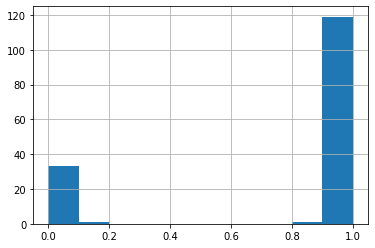

In [411]:
case_number = data.shape[0]
na_per_cols = data.isna().sum()/case_number
na_per_cols.hist()

Dropping empty columns to ease our work.

In [412]:
def drop_na(data: pd.DataFrame, na_cutoff: float = 1.0) -> pd.DataFrame:
    """ "Drop columns with a percentage of na values greater than
    or equal to `na_cutoff` and returns a new DataFrame"""
    
    case_number = data.shape[0]
    na_per_cols = data.isna().sum() / case_number
    cols_to_remove = na_per_cols[na_per_cols >= na_cutoff].index
    clean_data = data.drop(cols_to_remove, axis="columns", inplace=False)
    return clean_data


data_prep = drop_na(data)
data_prep.describe()


,age_at_index,days_to_birth,days_to_death,year_of_birth,year_of_death,age_at_diagnosis,days_to_diagnosis,days_to_last_follow_up,year_of_diagnosis
count,2164.000000,2134.000000,300.000000,2158.000000,206.000000,2134.000000,2164.0,1958.000000,2160.000000
mean,58.477819,-21593.057170,1570.720000,1949.386469,2004.436893,21593.057170,0.0,1179.631256,2007.868519
std,13.222725,4816.073815,1303.085144,13.616437,4.418740,4816.073815,0.0,1182.601155,4.312195
min,26.000000,-32872.000000,0.000000,1902.000000,1992.000000,9706.000000,0.0,-7.000000,1988.000000
25%,49.000000,-24868.750000,612.000000,1940.000000,2001.000000,18038.000000,0.0,424.250000,2007.000000
50%,58.000000,-21562.000000,1147.000000,1950.000000,2005.000000,21562.000000,0.0,760.000000,2009.000000
75%,67.000000,-18038.000000,2296.000000,1960.000000,2008.000000,24868.750000,0.0,1583.250000,2010.000000
max,90.000000,-9706.000000,7455.000000,1984.000000,2013.000000,32872.000000,0.0,8605.000000,2013.000000


## 2. Categorical features

### 2.A. First look at possible categorical features

Unique values for non-numeric features

In [413]:
unique_values_per_col = data_prep.select_dtypes(exclude="number").apply(lambda col: pd.unique(col).shape[0]).sort_values() 
unique_values_per_col

tumor_grade                       1
project_id                        1
progression_or_recurrence         1
last_known_disease_status         1
classification_of_tumor           1
treatment_type                    2
gender                            2
vital_status                      2
synchronous_malignancy            2
treatment_or_therapy              3
prior_malignancy                  3
prior_treatment                   3
ethnicity                         3
ajcc_pathologic_m                 4
race                              5
ajcc_staging_system_edition       6
site_of_resection_or_biopsy       6
tissue_or_organ_of_origin         6
icd_10_code                       7
ajcc_pathologic_t                12
ajcc_pathologic_stage            13
tumor_stage                      13
ajcc_pathologic_n                16
morphology                       22
primary_diagnosis                22
case_submitter_id              1082
case_id                        1082
dtype: int64

* Some categorical features have a single value: to be removed
* Most other features have low cardinality (2-22)
* There are 1082 distinct `case_id` and `case_submitter_id`, so we can remove the latter

In [414]:
def remove_low_cardinality_features(data: pd.DataFrame) -> pd.DataFrame:
    """Remove feature with low cardinality"""
    feature_cardinality = data.select_dtypes(exclude="number").apply(
        lambda col: pd.unique(col).shape[0]
    )  # `pd.unique` includes na values
    cols_to_remove = feature_cardinality[feature_cardinality == 1].index
    return data.drop(columns=cols_to_remove)

def remove_unwanted_features(data, features: List[str]) -> pd.DataFrame:
    """Remove features from a dataframe not raising error if some features are not present.
    Useful for pipeline use."""
    return data.drop(columns=features, errors="ignore")

data_prep = (
    data.pipe(drop_na)
    .pipe(remove_low_cardinality_features)
    .pipe(remove_unwanted_features, ["case_submitter_id"])
)

Looking into these categorical features

In [415]:
{col: data_prep[col].unique() for col in data_prep[unique_values_per_col[(unique_values_per_col<30) & (unique_values_per_col>1)].index]}

{'treatment_type': array(['Radiation Therapy, NOS', 'Pharmaceutical Therapy, NOS'],
       dtype=object),
 'gender': array(['female', 'male'], dtype=object),
 'vital_status': array(['Alive', 'Dead'], dtype=object),
 'synchronous_malignancy': array(['No', 'Not Reported'], dtype=object),
 'treatment_or_therapy': array(['yes', 'no', 'not reported'], dtype=object),
 'prior_malignancy': array(['no', 'yes', 'not reported'], dtype=object),
 'prior_treatment': array(['No', 'Yes', 'Not Reported'], dtype=object),
 'ethnicity': array(['not hispanic or latino', 'not reported', 'hispanic or latino'],
       dtype=object),
 'ajcc_pathologic_m': array(['M0', 'MX', 'M1', 'cM0 (i+)'], dtype=object),
 'race': array(['white', 'asian', 'black or african american', 'not reported',
        'american indian or alaska native'], dtype=object),
 'ajcc_staging_system_edition': array(['3rd', '6th', '7th', nan, '4th', '5th'], dtype=object),
 'site_of_resection_or_biopsy': array(['Breast, NOS', 'Overlapping lesion 

Although there are some cleaning to do (letter case for instance), it doesn't impact the number of categories for each feature.

### 2.B. Changing the type to `category` for these features.

Looking for NA values into these categorical features.

In [416]:
def show_na(data: pd.DataFrame) -> None:
    na_values = data.select_dtypes(exclude="number").isna().sum()
    cols_with_na = na_values[na_values>0].index
    for col in cols_with_na:
        print(col)
        print(data_prep[col].value_counts(dropna=False))
        print()

show_na(data_prep)


ajcc_pathologic_stage
Stage IIA     708
Stage IIB     508
Stage IIIA    306
Stage I       178
Stage IA      170
Stage IIIC    122
Stage IIIB     54
Stage IV       40
Stage X        26
NaN            22
Stage IB       14
Stage II       12
Stage III       4
Name: ajcc_pathologic_stage, dtype: int64

ajcc_staging_system_edition
6th    880
7th    818
NaN    282
5th    110
4th     58
3rd     16
Name: ajcc_staging_system_edition, dtype: int64



There are only two features with NA values. At first we can fill them similarly to other with "Not Reported", and then change the categorical feature type

In [417]:
def categorize_features(data: pd.DataFrame) -> pd.DataFrame:
    """Change object type to category type and fill na values."""
    cat_columns = data.select_dtypes(exclude="number").columns
    data_categorized = data.copy()
    #data_categorized[cat_columns] = np.asarray(data_categorized[cat_columns])
    data_categorized[cat_columns] = data_categorized[cat_columns].fillna(value="Not Reported")
    data_categorized[cat_columns] = data_categorized[cat_columns].astype(dtype="category")
    return data_categorized

data_prep = (
    data.pipe(drop_na)
    .pipe(remove_low_cardinality_features)
    .pipe(remove_unwanted_features, ["case_submitter_id"])
    .pipe(categorize_features)
)


### 2.C Multiple lines for each `case_id`

In [418]:
data_prep["case_id"].value_counts().value_counts()

2    1082
Name: case_id, dtype: int64

We have exactly 2 lines for each `case_id`.

#### Finding differences between rows of `case_id`

In [419]:
def identical_fields(group):
    """"Check every column for every pair of `case_id`
    Warning: Can take up to a minute to run."""
    identical = []

    def diff(group, col):
        return group.iloc[0].loc[col]!=group.iloc[1].loc[col]
    
    def not_nan(group, col):
        return pd.notna(group.iloc[0].loc[col]) or pd.notna(group.iloc[1].loc[col])
    
    for col in group.columns:
        if diff(group, col) and not_nan(group, col):
            identical.append(col)
    return identical
    
identical_fields_per_case_id = data_prep.groupby(by="case_id").apply(identical_fields)
identical_fields_per_case_id[~identical_fields_per_case_id.duplicated()]


case_id
001cef41-ff86-4d3f-a140-a647ac4b10a1    [treatment_or_therapy, treatment_type]
0045349c-69d9-4306-a403-c9c1fa836644                          [treatment_type]
dtype: object

There are only two features that have distinct values between each row of a `case_id`: `treatment_or_therapy` and `treatment_type`.

In [420]:
data_prep["treatment_type"].value_counts()

Pharmaceutical Therapy, NOS    1082
Radiation Therapy, NOS         1082
Name: treatment_type, dtype: int64

For each `case_id` we have two rows, one for each `treatment_type`. The `treatment_or_therapy` problably indicating the admission or not of the `treatment_type`.

### 2.D. Transforming `treatment_type` to get wide data

In [421]:
def widen_treatment_type(data: pd.DataFrame) -> pd.DataFrame:
    """Transform `treatment_type`into ditsinct columns with value `treatment_or_therapy`"""
    index_cols_for_pivot = data.columns.tolist()
    index_cols_for_pivot.remove("treatment_type")
    index_cols_for_pivot.remove("treatment_or_therapy")

    wide_data = data.pivot(index=index_cols_for_pivot, columns="treatment_type", values="treatment_or_therapy").reset_index().rename_axis(columns=None)
    return wide_data

In [422]:
data_prep = (
    data.pipe(drop_na)
    .pipe(remove_low_cardinality_features)
    .pipe(remove_unwanted_features, ["case_submitter_id"])
    .pipe(categorize_features)
    .pipe(widen_treatment_type)
)
data_prep.head()

,case_id,age_at_index,days_to_birth,days_to_death,ethnicity,gender,race,vital_status,year_of_birth,year_of_death,...,primary_diagnosis,prior_malignancy,prior_treatment,site_of_resection_or_biopsy,synchronous_malignancy,tissue_or_organ_of_origin,tumor_stage,year_of_diagnosis,"Pharmaceutical Therapy, NOS","Radiation Therapy, NOS"
0,001cef41-ff86-4d3f-a140-a647ac4b10a1,60,-22279.0,NaN,not hispanic or latino,female,white,Alive,1950.0,NaN,...,"Infiltrating duct carcinoma, NOS",no,No,"Breast, NOS",No,"Breast, NOS",stage ia,2010.0,yes,no
1,0045349c-69d9-4306-a403-c9c1fa836644,70,-25833.0,NaN,not hispanic or latino,female,white,Alive,1938.0,NaN,...,Adenoid cystic carcinoma,no,No,"Breast, NOS",No,"Breast, NOS",stage i,2008.0,not reported,not reported
2,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,50,-18345.0,NaN,not hispanic or latino,female,white,Alive,1955.0,NaN,...,Apocrine adenocarcinoma,no,No,"Breast, NOS",No,"Breast, NOS",stage iib,2005.0,yes,no
3,00a2d166-78c9-4687-a195-3d6315c27574,56,-20713.0,NaN,not hispanic or latino,female,white,Alive,1954.0,NaN,...,"Infiltrating duct carcinoma, NOS",no,No,"Breast, NOS",No,"Breast, NOS",stage iia,2010.0,no,no
4,00b11ca8-8540-4a3d-b602-ec754b00230b,61,-22497.0,NaN,not hispanic or latino,female,white,Alive,1951.0,NaN,...,"Lobular carcinoma, NOS",yes,No,"Breast, NOS",Not Reported,"Breast, NOS",stage ia,2012.0,yes,no


### 2.E. Plotting categorical features

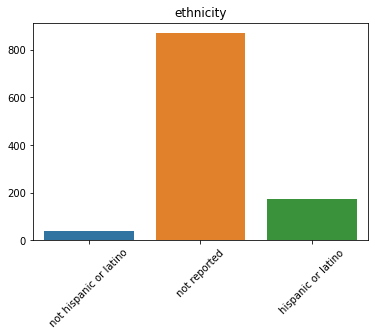

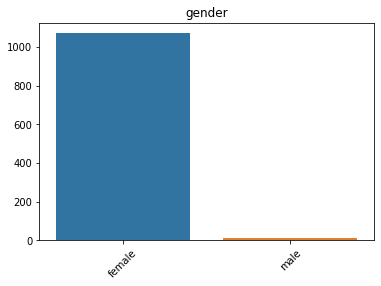

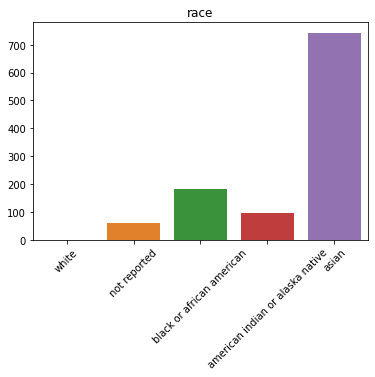

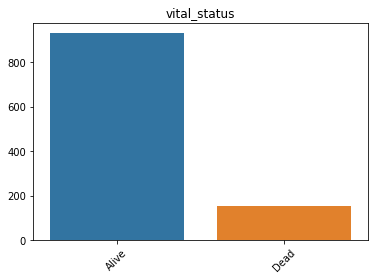

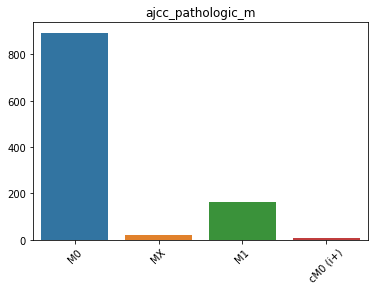

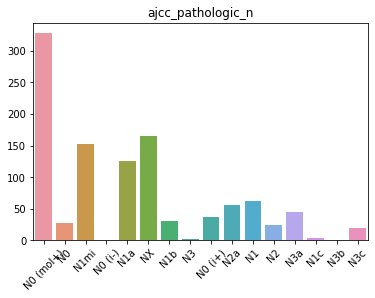

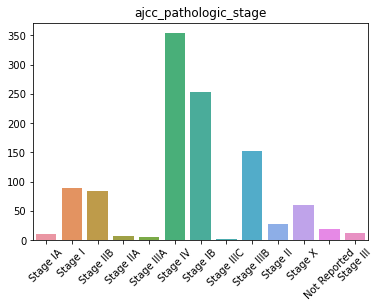

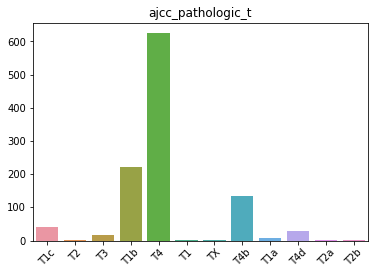

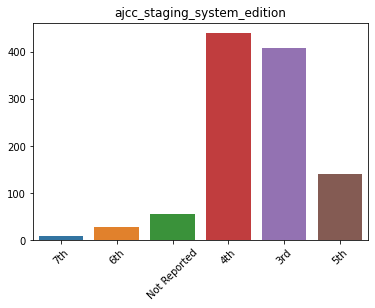

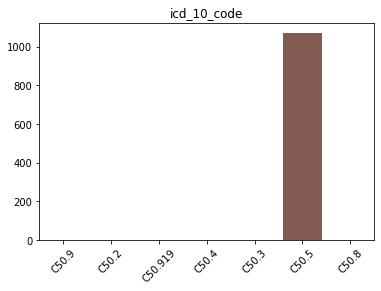

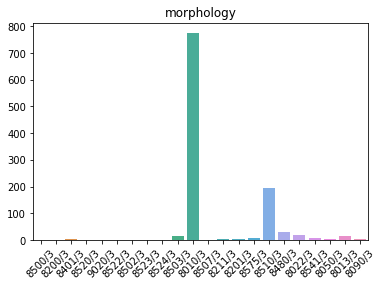

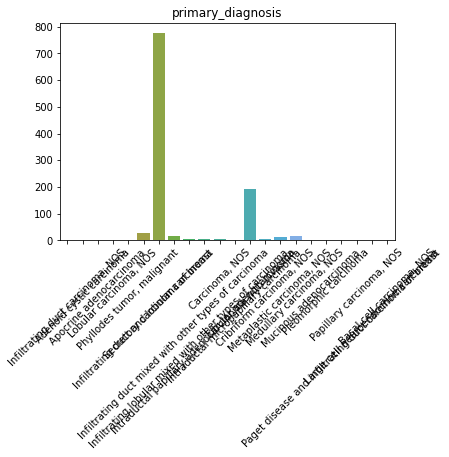

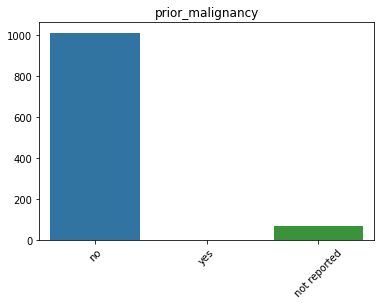

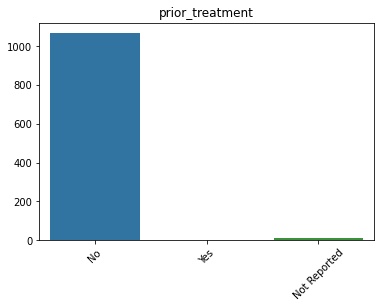

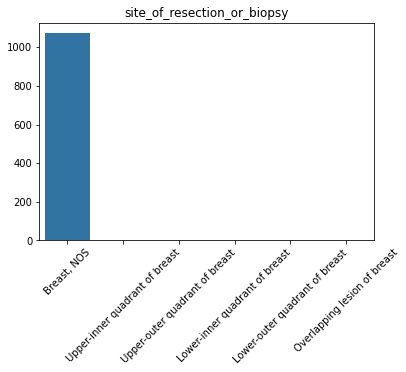

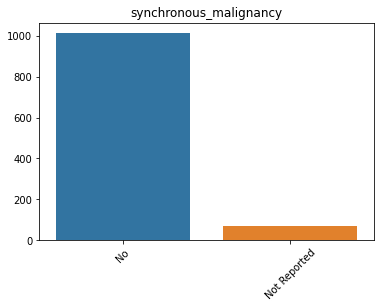

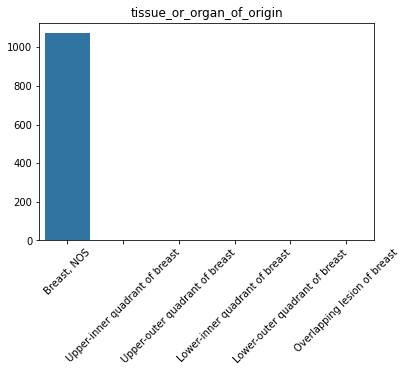

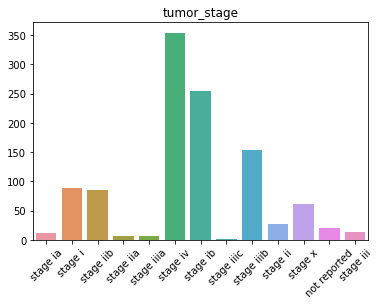

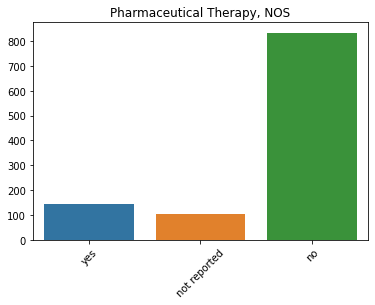

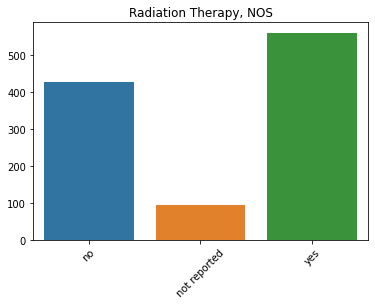

In [431]:
col_to_plot = data_prep.select_dtypes(exclude="number").columns.to_list()
col_to_plot.remove("case_id")
for col in col_to_plot:
    data_to_plot = data_prep[col].value_counts()
    p = sns.barplot(x=data_to_plot.index, y=data_to_plot.values)
    p.set_title(col)
    p.set_xticklabels(labels=data_prep[col].unique(), rotation=45)
    plt.show()

### 2.F. Categorical feature entropy

In [453]:
data_prep.select_dtypes(exclude="number").apply(lambda x: entropy(x.value_counts())).sort_values()

gender                         0.060955
tissue_or_organ_of_origin      0.066880
site_of_resection_or_biopsy    0.066880
icd_10_code                    0.074253
prior_treatment                0.078524
synchronous_malignancy         0.237219
prior_malignancy               0.242050
vital_status                   0.404157
ajcc_pathologic_m              0.549944
ethnicity                      0.583944
Pharmaceutical Therapy, NOS    0.693560
Radiation Therapy, NOS         0.919755
race                           0.940117
primary_diagnosis              1.034158
morphology                     1.034158
ajcc_pathologic_t              1.273305
ajcc_staging_system_edition    1.283927
ajcc_pathologic_stage          1.888480
tumor_stage                    1.888480
ajcc_pathologic_n              2.135040
case_id                        6.986566
dtype: float64

## 3. Numerical data

In [425]:
data_prep.select_dtypes(include="number").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age_at_index            1082 non-null   int64  
 1   days_to_birth           1067 non-null   float64
 2   days_to_death           150 non-null    float64
 3   year_of_birth           1079 non-null   float64
 4   year_of_death           103 non-null    float64
 5   age_at_diagnosis        1067 non-null   float64
 6   days_to_diagnosis       1082 non-null   int64  
 7   days_to_last_follow_up  979 non-null    float64
 8   year_of_diagnosis       1080 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 76.2 KB


In [426]:
data_prep.select_dtypes(include="number").describe()

,age_at_index,days_to_birth,days_to_death,year_of_birth,year_of_death,age_at_diagnosis,days_to_diagnosis,days_to_last_follow_up,year_of_diagnosis
count,1082.000000,1067.000000,150.000000,1079.000000,103.000000,1067.000000,1082.0,979.000000,1080.000000
mean,58.477819,-21593.057170,1570.720000,1949.386469,2004.436893,21593.057170,0.0,1179.631256,2007.868519
std,13.225783,4817.203156,1305.269697,13.619595,4.429557,4817.203156,0.0,1182.903417,4.313194
min,26.000000,-32872.000000,0.000000,1902.000000,1992.000000,9706.000000,0.0,-7.000000,1988.000000
25%,49.000000,-24862.500000,612.500000,1940.000000,2001.000000,18038.000000,0.0,424.500000,2007.000000
50%,58.000000,-21562.000000,1147.000000,1950.000000,2005.000000,21562.000000,0.0,760.000000,2009.000000
75%,67.000000,-18038.000000,2290.250000,1960.000000,2008.000000,24862.500000,0.0,1579.500000,2010.000000
max,90.000000,-9706.000000,7455.000000,1984.000000,2013.000000,32872.000000,0.0,8605.000000,2013.000000


* Most of this data will be highly correlated since it is different representation of the same information (birthdate, diagnosis date, death date)
* Data seems to be integer values
* `days_to_diagnosis` is empty

### 3.A Float to Int

Let's try to convert float to int.

In [427]:
_ = data_prep.select_dtypes(include="number").apply(lambda col: col.astype("Int64"))

No error, all data seems to be integer values

In [428]:
def convert_to_int(data: pd.DataFrame) -> pd.DataFrame:
    """Convert float value to integer. Will raise an error if float values are not rounded numbers."""
    data_num = data.select_dtypes(include="number")
    data_converted = data.copy()
    data_converted[data_num.columns] = data_num.apply(lambda col: col.astype("Int64"))
    return data_converted

In [435]:
data_prep = (
    data.pipe(drop_na)
    .pipe(remove_low_cardinality_features)
    .pipe(remove_unwanted_features, ["case_submitter_id"])
    .pipe(widen_treatment_type)
    .pipe(remove_unwanted_features, ["days_to_diagnosis"])
    .pipe(categorize_features)
    .pipe(convert_to_int)
)

data_prep_num  = data_prep.select_dtypes(include="number")
data_prep_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   age_at_index            1082 non-null   Int64
 1   days_to_birth           1067 non-null   Int64
 2   days_to_death           150 non-null    Int64
 3   year_of_birth           1079 non-null   Int64
 4   year_of_death           103 non-null    Int64
 5   age_at_diagnosis        1067 non-null   Int64
 6   days_to_last_follow_up  979 non-null    Int64
 7   year_of_diagnosis       1080 non-null   Int64
dtypes: Int64(8)
memory usage: 76.2 KB


### 3.B. Plotting numerical features

Plotting data to identify errors and correlations.

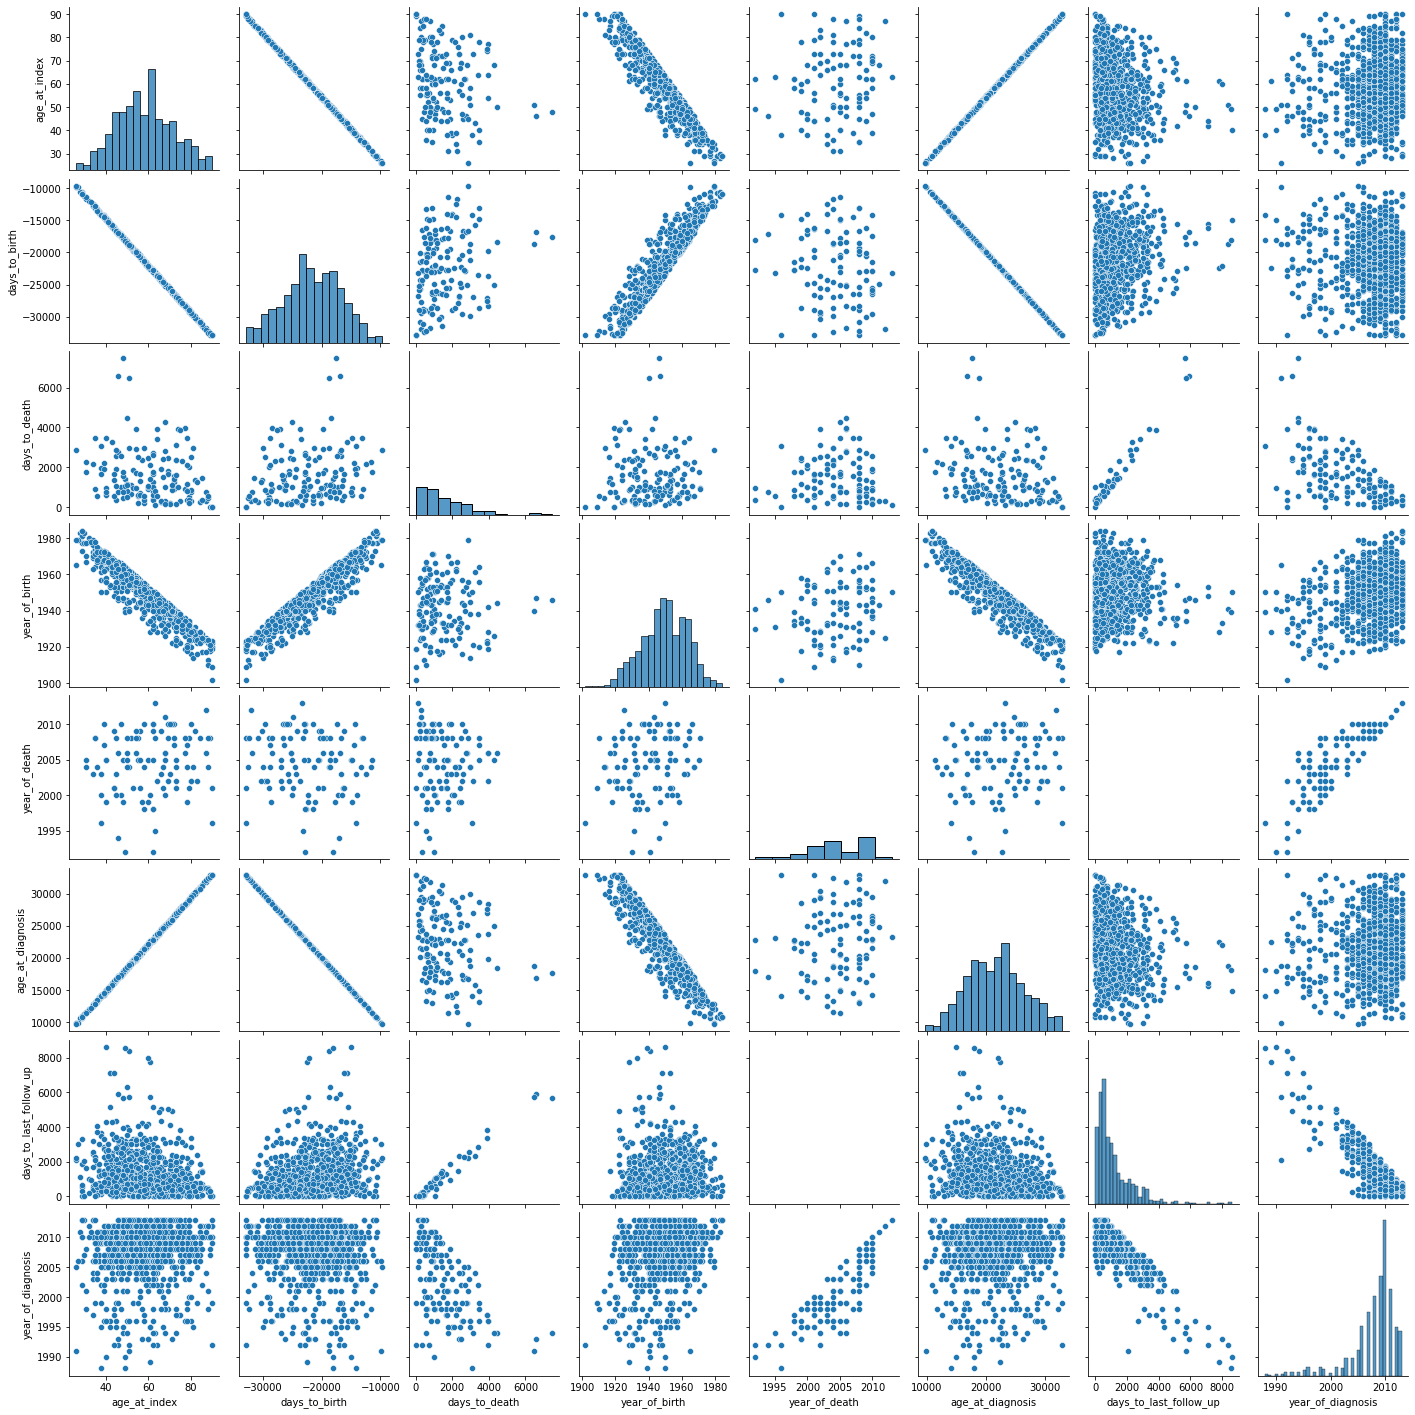

In [ ]:
sns.pairplot(data_prep_num)

Plots confirm the correlations for birth, diagnosis and death information respectively.

## 4. Death information

### 4.A. `vital_status` analysis

Date of death should be empty for `vital_status=="Alive"` and filled elsewhere.

In [ ]:
def check_death_info(data: pd.DataFrame) -> None:
    print(data[["days_to_death", "year_of_death", "vital_status"]].set_index("vital_status").isna().groupby(by="vital_status").value_counts())

check_death_info(data_prep)

vital_status  days_to_death  year_of_death
Alive         True           True             931
              False          False              0
                             True               0
              True           False              0
Dead          False          False            103
                             True              47
              True           True               1
                             False              0
dtype: int64


* 1 missing death date
* 47 `year_of_death` missing but with `days_to_death` so we should be able to impute it
* No issue with `vital_state=="Alive"` status

### 4.B. Date calculations check

`age_at_index` should be equivalent to `days_to_birth`:

In [ ]:
(data_prep["age_at_index"]+data_prep["days_to_birth"]/365.25).describe()

count    1067.000000
mean       -0.502823
std         0.289877
min        -0.998631
25%        -0.748118
50%        -0.505818
75%        -0.251882
max         0.004107
dtype: float64

Differences betwean `year_of_*` information and `days_to_*` should be equivalent:

In [ ]:
death_no_na =  data_prep[data_prep["days_to_death"].notna() & data_prep["year_of_death"].notna()]
(
    death_no_na["year_of_death"]
    - death_no_na["year_of_birth"]
    + (-death_no_na["days_to_birth"] + death_no_na["days_to_death"]) / 365.25
).describe()


count    103.000000
mean      -0.851478
std        1.139278
min       -1.819986
25%       -1.305613
50%       -1.044490
75%       -0.746064
max        8.001369
dtype: float64

## 5. Data preparation and saving

In [464]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    data_prep = (
        data.pipe(drop_na)
        .pipe(remove_low_cardinality_features)
        .pipe(remove_unwanted_features, ["case_submitter_id"])
        .pipe(widen_treatment_type)
        .pipe(remove_unwanted_features, ["days_to_diagnosis"])
        .pipe(categorize_features)
        .pipe(convert_to_int)
    )
    return data_prep

def pickle_data(data: pd.DataFrame, path: str) -> None:
    data.to_pickle(path)

def read_data(path: str) -> pd.DataFrame:
    return pd.read_pickle(path)
    
prep_data = preprocess(data)
pickle_data(prep_data, DATA_DIR.joinpath(PREPROCESSED_FILENAME))




### Testing data export

In [465]:
import tempfile

def test_data_export(data: pd.DataFrame, path: str) -> None:
    pickle_data(data, path)
    saved_data = read_data(path)
    pd.testing.assert_frame_equal(saved_data, data)

with tempfile.TemporaryDirectory() as tmpdirname:
    test_data_export(prep_data, pathlib.Path(tmpdirname).joinpath(PREPROCESSED_FILENAME))